In [1]:
import pandas as pd
from typing import List, Dict, Optional

def load_loss_intervals_with_gap(
        csv_path: str,
        max_batch_idx: int = 13,
        gap_threshold: int = 6
    ) -> List[Dict[int, Optional[float]]]:
    """
    讀取 loss_log.csv，當「下一筆 batch_idx 與前一筆 batch_idx 的差值」> gap_threshold
    時視為跨區間，將資料切割成多個區間清單。

    每個區間以 {batch_idx: total_loss, …} 形式呈現；
    若該區間缺少某些 batch_idx，則以 None 補位。

    Parameters
    ----------
    csv_path : str
        CSV 檔路徑
    max_batch_idx : int, default 13
        區間內保留的最大 batch_idx（如 1~13）
    gap_threshold : int, default 6
        判定跨區間的差值門檻

    Returns
    -------
    List[Dict[int, Optional[float]]]
        依序排列的區間清單
    """
    df = pd.read_csv(csv_path)

    intervals: List[Dict[int, Optional[float]]] = []
    current: Dict[int, Optional[float]] = {}
    prev_idx: Optional[int] = None

    for _, row in df.iterrows():
        idx  = int(row["batch_idx"])
        loss = float(row["total_loss"])

        # 只關注 1 ~ max_batch_idx
        if idx > max_batch_idx:
            continue

        # 若前後索引差值大於門檻，視為跨區間
        if prev_idx is not None and abs(idx - prev_idx) > gap_threshold:
            for i in range(1, max_batch_idx + 1):
                current.setdefault(i, None)   # 補齊缺失值
            intervals.append(current)
            current = {}

        # 收集當前批次的 total_loss
        current[idx] = loss
        prev_idx = idx

    # 收尾最後一段
    if current:
        for i in range(1, max_batch_idx + 1):
            current.setdefault(i, None)
        intervals.append(current)

    return intervals


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_analyze_loss_data(csv_path):
    """
    載入並分析損失數據的完整統計分析
    
    Args:
        csv_path (str): CSV 檔案路徑
        
    Returns:
        dict: 包含所有統計分析結果的字典
    """
    # 讀取 CSV 檔案
    df = pd.read_csv(csv_path)
    
    # 定義需要分析的損失欄位
    loss_columns = ["original_loss", "auxiliary_loss", "normalized_auxiliary_loss", "total_loss"]
    
    # 基本統計量計算
    basic_stats = {}
    for col in loss_columns:
        data = df[col].values
        basic_stats[col] = {
            "count": len(data),
            "mean": np.mean(data),
            "median": np.median(data),
            "std": np.std(data),
            "var": np.var(data),
            "min": np.min(data),
            "max": np.max(data),
            "range": np.max(data) - np.min(data),
            "q25": np.percentile(data, 25),
            "q75": np.percentile(data, 75),
            "iqr": np.percentile(data, 75) - np.percentile(data, 25),
            "skewness": skew(data),
            "kurtosis": kurtosis(data),
            "cv": np.std(data) / np.mean(data)  # 變異係數
        }
    
    # 相關性分析
    correlation_matrix = df[loss_columns].corr()
    
    # 異常值檢測 (3σ 法則)
    outliers = {}
    for col in loss_columns:
        data = df[col].values
        mean = np.mean(data)
        std = np.std(data)
        outlier_threshold = 3 * std
        outliers[col] = {
            "upper_bound": mean + outlier_threshold,
            "lower_bound": mean - outlier_threshold,
            "outlier_count": len(data[(data > mean + outlier_threshold) | (data < mean - outlier_threshold)]),
            "outlier_percentage": len(data[(data > mean + outlier_threshold) | (data < mean - outlier_threshold)]) / len(data) * 100
        }
    
    # 批次統計
    batch_stats = df.groupby('batch_idx')[loss_columns].agg(['mean', 'std', 'count'])
    
    # 時間序列分析
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    time_stats = {
        "duration": (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600,  # 小時
        "total_records": len(df),
        "avg_records_per_hour": len(df) / ((df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600)
    }
    
    return {
        "basic_stats": basic_stats,
        "correlation_matrix": correlation_matrix,
        "outliers": outliers,
        "batch_stats": batch_stats,
        "time_stats": time_stats,
        "raw_data": df
    }

def print_analysis_results(analysis_results):
    """
    格式化輸出統計分析結果
    """
    print("=" * 60)
    print("LCP 損失訓練數據統計分析報告")
    print("=" * 60)
    
    # 基本統計量
    print("\n📊 基本統計量:")
    print("-" * 50)
    for loss_type, stats in analysis_results["basic_stats"].items():
        print(f"\n{loss_type.upper()}:")
        print(f"  平均值: {stats['mean']:.6f}")
        print(f"  中位數: {stats['median']:.6f}")
        print(f"  標準差: {stats['std']:.6f}")
        print(f"  最小值: {stats['min']:.6f}")
        print(f"  最大值: {stats['max']:.6f}")
        print(f"  偏度: {stats['skewness']:.3f}")
        print(f"  峰度: {stats['kurtosis']:.3f}")
        print(f"  變異係數: {stats['cv']:.3f}")
    
    # 相關性矩陣
    print("\n🔗 相關性矩陣:")
    print("-" * 50)
    print(analysis_results["correlation_matrix"].round(3))
    
    # 異常值檢測
    print("\n⚠️  異常值檢測 (3σ 法則):")
    print("-" * 50)
    for loss_type, outlier_info in analysis_results["outliers"].items():
        print(f"{loss_type}: {outlier_info['outlier_count']} 個異常值 ({outlier_info['outlier_percentage']:.2f}%)")
    
    # 時間統計
    print("\n⏱️  時間統計:")
    print("-" * 50)
    print(f"訓練總時長: {analysis_results['time_stats']['duration']:.2f} 小時")
    print(f"總記錄數: {analysis_results['time_stats']['total_records']}")
    print(f"平均每小時記錄數: {analysis_results['time_stats']['avg_records_per_hour']:.2f}")

In [20]:
def filter(datas, lower_bound=None, upper_bound=None, use_3sigma=True):
    """
    過濾資料中 value 為 None 或超出異常值範圍的項目
    
    Args:
        datas (list of dict): 要過濾的資料列表，每個元素為字典
        lower_bound (float): 自定義下界，低於此值視為異常
        upper_bound (float): 自定義上界，高於此值視為異常
        use_3sigma (bool): 是否使用 3σ 法則自動計算異常值界限
    
    Returns:
        list of dict: 過濾後的資料列表
    """
    import numpy as np
    
    # 如果啟用 3σ 法則，自動計算異常值界限
    if use_3sigma:
        all_values = []
        for data_dict in datas:
            for value in data_dict.values():
                if value is not None:
                    all_values.append(value)
        
        if all_values:
            mean = np.mean(all_values)
            std = np.std(all_values)
            calculated_lower = mean - 3 * std
            calculated_upper = mean + 3 * std
            
            # 使用計算出的界限（如果沒有自定義界限的話）
            if lower_bound is None:
                lower_bound = calculated_lower
            if upper_bound is None:
                upper_bound = calculated_upper
    
    filtered_datas = []
    stats = {
        'total_items': len(datas),
        'none_count': 0,
        'outlier_count': 0,
        'valid_count': 0
    }
    
    for i in datas:
        new_dict = {}
        for key, value in i.items():
            # 過濾 None 值
            if value is None:
                stats['none_count'] += 1
                continue
                
            # 過濾異常值
            is_outlier = False
            if lower_bound is not None and value < lower_bound:
                is_outlier = True
            if upper_bound is not None and value > upper_bound:
                is_outlier = True
                
            if is_outlier:
                stats['outlier_count'] += 1
                continue
                
            # 保留有效值
            new_dict[key] = value
            stats['valid_count'] += 1
        
        # 只保留非空的字典
        if new_dict:
            filtered_datas.append(new_dict)
    
    # 輸出統計信息
    print(f"過濾統計:")
    print(f"  原始區間數: {stats['total_items']}")
    print(f"  None 值數量: {stats['none_count']}")
    print(f"  異常值數量: {stats['outlier_count']}")
    print(f"  有效值數量: {stats['valid_count']}")
    if lower_bound is not None and upper_bound is not None:
        print(f"  異常值界限: [{lower_bound:.3f}, {upper_bound:.3f}]")
    
    return filtered_datas


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

def fill_nan_dynamic(intervals: List[Dict[int, float]]) -> List[Dict[int, float]]:
    """
    針對每個區段字典，自動補上缺失的 batch_idx，
    並將缺失處以 np.nan 佔位，使 x 軸保持真實間距。
    """
    filled = []

    for block in intervals:
        if not block:                     # 避免空字典
            filled.append({})
            continue

        # 1. 依照目前區段最大索引決定補齊範圍
        print( f"block : { block }")
        max_idx = max(block)
        complete = {}

        for k in range(1, max_idx + 1):
            complete[k] = block.get(k, np.nan)   # 若原本無該 key → 直接放 NaN

        filled.append(complete)

    return filled


def plot_intervals(intervals: List[Dict[int, float]],
                   title: str = "Total-Loss per Batch (auto-NaN filled)"):
    """
    將填補後的區段一次畫在同一張圖中，缺失點自動斷線。
    """
    if not intervals:
        raise ValueError("interval list is empty")

    plt.figure(figsize=(10, 6))
    cmap = plt.cm.get_cmap("tab10", len(intervals))

    for i, block in enumerate(intervals, 1):
        x = sorted(block)                      # 已連續
        y = [block[k] for k in x]              # 可能含 NaN
        plt.plot(
            x, y,
            marker="o",
            linewidth=2,
            markersize=5,
            label=f"Interval {i}",
            color=cmap(i - 1)
        )

    plt.title(title)
    plt.xlabel("batch_idx")
    plt.ylabel("total_loss")
    plt.grid(alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
csv_file = "loss_log.csv"          # 替換成實際檔案路徑
intervals = load_loss_intervals_with_gap(
                csv_path=csv_file,
                max_batch_idx=55,   # 需要多少批次就設多少
                gap_threshold=7     # |next_idx - pre_idx| > 6 視為新區間
            )

# 印出前兩個區間
intervals = filter(intervals)  # 過濾掉 None 值
from pprint import pprint
pprint(intervals)


過濾統計:
  原始區間數: 20
  None 值數量: 746
  異常值數量: 2
  有效值數量: 352
  異常值界限: [-2.769, 8.135]
[{1: 4.818432331085205,
  3: 4.892481803894043,
  4: 4.715378284454346,
  5: 4.588389873504639,
  6: 4.148372650146484,
  7: 4.238167762756348,
  8: 4.132227897644043,
  9: 3.5942630767822266,
  10: 3.8054513931274414,
  12: 3.7750730514526367},
 {1: 3.458238363265991,
  3: 3.718156576156616,
  4: 3.7526986598968506,
  5: 3.413637161254883,
  6: 3.206505298614502,
  7: 3.312157154083252,
  8: 3.106703996658325,
  9: 2.805564641952514,
  10: 2.668274402618408,
  11: 2.7600207328796387,
  12: 2.669313907623291},
 {1: 2.9563229084014893,
  2: 2.813375949859619,
  4: 2.7492642402648926,
  5: 2.673044204711914,
  6: 2.8760170936584477,
  7: 2.6494781970977783,
  8: 2.4803402423858643,
  9: 1.979732871055603,
  10: 2.4128506183624268,
  11: 2.5155038833618164,
  12: 2.401995182037353},
 {1: 2.302215576171875,
  2: 2.2874155044555664,
  3: 2.22778844833374,
  4: 2.1925668716430664,
  5: 2.0436086654663086,
  6:

In [23]:
analysis_results = load_and_analyze_loss_data("loss_log.csv")
    
# 輸出分析結果
print_analysis_results(analysis_results)

# 額外統計分析
print("\n📈 進階統計分析:")
print("-" * 50)

# 損失穩定性分析
df = analysis_results["raw_data"]

# 計算各損失類型的穩定性指標
stability_metrics = {}
for col in ["original_loss", "auxiliary_loss", "normalized_auxiliary_loss", "total_loss"]:
    data = df[col].values
    stability_metrics[col] = {
        "stability_index": 1 / (1 + np.std(data) / np.mean(data)),  # 穩定性指數
        "consistency_ratio": np.median(data) / np.mean(data),  # 一致性比率
        "volatility": np.std(np.diff(data)) / np.mean(data)  # 波動率
    }

print("穩定性指標:")
for loss_type, metrics in stability_metrics.items():
    print(f"{loss_type}:")
    print(f"  穩定性指數: {metrics['stability_index']:.3f}")
    print(f"  一致性比率: {metrics['consistency_ratio']:.3f}")
    print(f"  波動率: {metrics['volatility']:.3f}")

LCP 損失訓練數據統計分析報告

📊 基本統計量:
--------------------------------------------------

ORIGINAL_LOSS:
  平均值: 1.198843
  中位數: 1.036466
  標準差: 1.799803
  最小值: 0.028303
  最大值: 29.420666
  偏度: 12.474
  峰度: 180.751
  變異係數: 1.501

AUXILIARY_LOSS:
  平均值: 4.688180
  中位數: 4.617814
  標準差: 0.284694
  最小值: 4.388378
  最大值: 6.062732
  偏度: 2.746
  峰度: 8.819
  變異係數: 0.061

NORMALIZED_AUXILIARY_LOSS:
  平均值: 1.484269
  中位數: 1.313929
  標準差: 0.514846
  最小值: 1.142289
  最大值: 4.474317
  偏度: 3.503
  峰度: 13.113
  變異係數: 0.347

TOTAL_LOSS:
  平均值: 2.683113
  中位數: 2.492579
  標準差: 1.817206
  最小值: 1.289578
  最大值: 30.952948
  偏度: 12.171
  峰度: 174.797
  變異係數: 0.677

🔗 相關性矩陣:
--------------------------------------------------
                           original_loss  auxiliary_loss  \
original_loss                      1.000          -0.001   
auxiliary_loss                    -0.001           1.000   
normalized_auxiliary_loss         -0.109           0.143   
total_loss                         0.960           0.040   

     

block : {1: 4.818432331085205, 3: 4.892481803894043, 4: 4.715378284454346, 5: 4.588389873504639, 6: 4.148372650146484, 7: 4.238167762756348, 8: 4.132227897644043, 9: 3.5942630767822266, 10: 3.8054513931274414, 12: 3.7750730514526367}
block : {1: 3.458238363265991, 3: 3.718156576156616, 4: 3.7526986598968506, 5: 3.413637161254883, 6: 3.206505298614502, 7: 3.312157154083252, 8: 3.106703996658325, 9: 2.805564641952514, 10: 2.668274402618408, 11: 2.7600207328796387, 12: 2.669313907623291}
block : {1: 2.9563229084014893, 2: 2.813375949859619, 4: 2.7492642402648926, 5: 2.673044204711914, 6: 2.8760170936584477, 7: 2.6494781970977783, 8: 2.4803402423858643, 9: 1.979732871055603, 10: 2.4128506183624268, 11: 2.5155038833618164, 12: 2.401995182037353}
block : {1: 2.302215576171875, 2: 2.2874155044555664, 3: 2.22778844833374, 4: 2.1925668716430664, 5: 2.0436086654663086, 6: 2.2112903594970703, 7: 1.795569658279419, 8: 1.7116564512252808, 9: 2.2981162071228027, 10: 1.6386889219284058, 11: 2.0863561

C:\Users\marti\AppData\Local\Temp\ipykernel_17644\73362212.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(intervals))


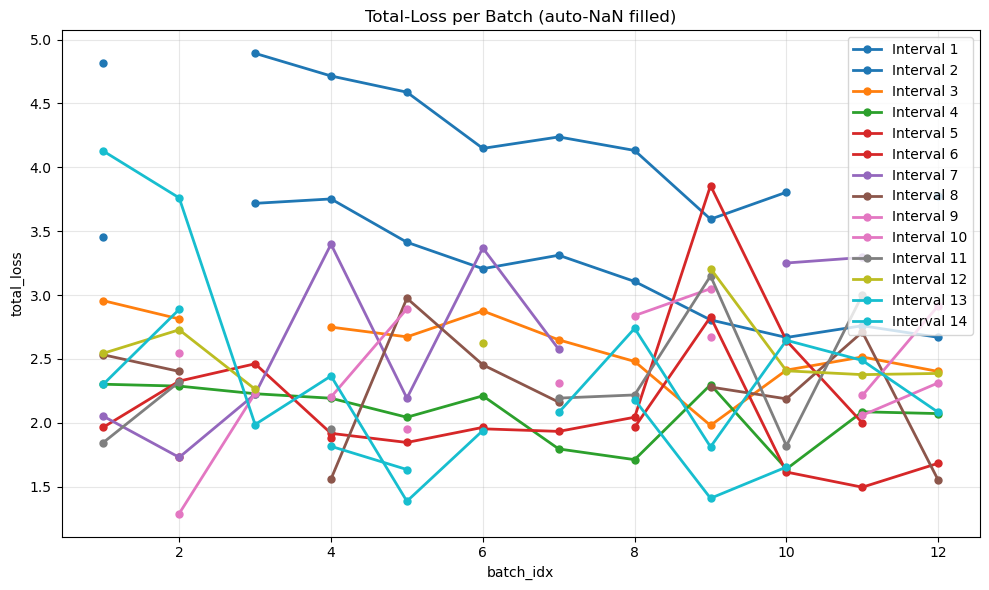

block : {1: 3.126958131790161, 3: 2.431595802307129, 4: 2.606266021728516, 5: 2.416654348373413, 6: 2.7213568687438965, 7: 2.310368299484253, 9: 2.182523250579834, 10: 2.9492502212524414, 12: 2.655531406402588, 13: 3.332056760787964, 14: 2.0059123039245605, 15: 2.278363943099976, 16: 2.796670436859131, 17: 2.1691455841064453, 20: 3.682446002960205, 22: 2.5798678398132324, 23: 1.6597517728805542, 25: 2.1876981258392334, 26: 2.335765838623047, 28: 3.1714677810668945, 29: 2.825417995452881, 31: 2.670684099197388, 32: 3.166745185852051, 33: 3.1889662742614746, 34: 2.597939729690552, 35: 2.071103096008301, 37: 2.028536319732666, 38: 1.8037281036376955, 39: 2.4974937438964844, 40: 2.467933177947998, 41: 2.259754180908203, 43: 2.1489791870117188, 44: 2.397146224975586, 45: 1.8289659023284912, 46: 1.889822244644165, 47: 2.2940988540649414, 48: 2.445655345916748, 49: 2.59433913230896}
block : {1: 2.5310192108154297, 3: 2.8758387565612797, 4: 2.780008316040039, 5: 2.0718164443969727, 6: 2.511954

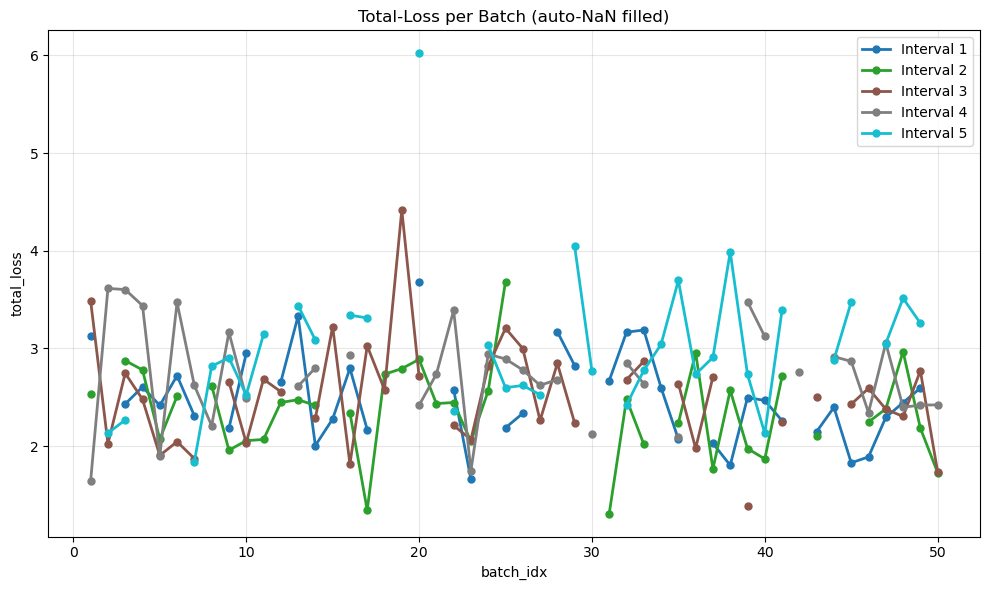

In [25]:
# for interval in intervals:
#     if not interval:  # 跳過空區間
#         continue
filled = fill_nan_dynamic(intervals[:14])
plot_intervals(filled)

filled = fill_nan_dynamic(intervals[15:])
plot_intervals(filled)